In [2]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, exp
from scipy.fft import fft2,ifft2,fftfreq,fft,ifft


F:\Anaconda3\anaconda\envs\numcomp\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


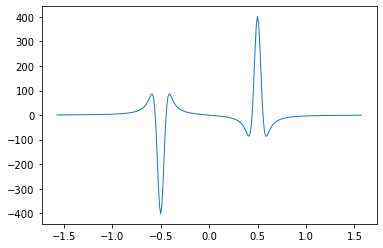

In [70]:
L = pi
nx = 256
a_sq = 0.05**2
x = np.linspace(0,L,nx)-L/2 + 1e-6
kx = fftfreq(nx,1/nx)*2*pi/L

v = (1-exp(-(x-0.5)**2/a_sq))/(x-0.5) - (1-exp(-(x+0.5)**2/a_sq))/(x+0.5)
# v = (1-exp(-(x)**2/a_sq))/(x)
# v[-1]=v[0]
vf = fft(v)
vx_f = vf*kx*1j
vx = ifft(vx_f)

theta = L*kx/nx 
sig_0 = 0.5*(1+np.cos(theta))
sig = sig_0**4*(35-84*sig_0 + 70*sig_0**2-20*sig_0**3)
vx_fil = np.real(ifft(vx_f*sig))

dx = L/nx
vx_fd = np.gradient(v,dx,axis=0)
plt.plot(x,vx,linewidth=1)
# plt.plot(x,vx_fil)
# plt.plot(x,vx_fd,linewidth=1)
# plt.plot(x,v)

plt.show()



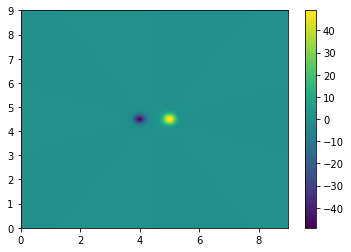

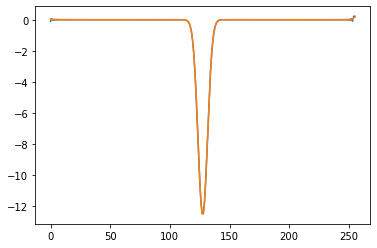

(-5044.26157876027, -5059.197505988145, -5061.513708100306)

In [141]:
nx=256
ny=256
L = 9

dx = L/nx
dy = L/ny

x = np.linspace(0,L,nx)
y = np.linspace(0,L,ny)
X,Y = np.meshgrid(x,y,indexing='ij')

kx = fftfreq(nx,1/nx)*2*pi/L
kx[0] = 1.0e-6
ky = fftfreq(ny,1/ny)*2*pi/L
ky[0] = 1.0e-6


# print(kx.max()/(2.0*pi))

M,N = np.meshgrid(kx,ky,indexing='ij')

kmax_2b3_x = 0.5*nx/3*2*pi/L 
kmax_2b3_y = 0.5*ny/3*2*pi/L  
dealias = np.array(
    (np.abs(M)<kmax_2b3_x)*
    (np.abs(N)<kmax_2b3_y),
    dtype = bool
    )

# k2 = (np.square(M) + np.square(N))
# kx 
# U = np.ones(X.shape)
V = np.zeros(X.shape)
U = Y
V = -X

a_sq = 0.2**2
x1    =  X-0.5*L-0.5
y1    =  Y-0.5*L
r_sq1 = np.square(x1) + np.square(y1) + 1e-6

x2    =  X-0.5*L + 0.5
y2    =  Y-0.5*L 
r_sq2 = np.square(x2) + np.square(y2) + 1e-6

U  = -(y1*(1-np.exp(-r_sq1/a_sq))/r_sq1) + (y2*(1-np.exp(-r_sq2/a_sq))/r_sq2)
V  =  (x1*(1-np.exp(-r_sq1/a_sq))/r_sq1) - (x2*(1-np.exp(-r_sq2/a_sq))/r_sq2) 

U[:,-1] = U[:,0]
V[:,-1] = V[:,0]
U[-1,:] = U[0,:]
V[-1,:] = V[0,:]

Uf = fft2(U,axes=(0,1))
Vf = fft2(V,axes=(0,1))
Wf = (M*Vf-N*Uf)*1j

# print(Wf.max())
theta = L*M/nx + L*N/ny
sig_0 = 0.5*(1+np.cos(theta))
sig = sig_0**4*(35-84*sig_0 + 70*sig_0**2-20*sig_0**3)
W = np.real(ifft2(Wf))

Wf_fil = Wf*sig
W_fil = np.real(ifft2(Wf_fil))

W_fd = np.gradient(V,dx,axis=0) - np.gradient(U,dy,axis=1)

# print(W_fd.shape)

# T = ifft2(Uf*M*1j)
T = ifft2(Uf*N*1j)
S = ifft2(Vf*M*1j)
D = S-T

plt.contourf(X,Y,W_fd,levels=200)
plt.colorbar()
plt.show()
# plt.contourf(X,Y,S,levels=200,cmap='jet')
# plt.colorbar()
# plt.show()
plt.plot(W[120,:])
# plt.plot(W_fd[90,:])
plt.plot(W_fil[120,:])
# plt.legend(("normal","fd",'filtered'))
# plt.plot(S[int(nx/2),:])
# plt.plot(T[90,:])
# plt.plot(V[200,:])
plt.show()
W[5:int(nx/2),5:-5].sum(),W_fil[5:int(nx/2),5:-5].sum(),W_fd[5:int(nx/2),5:-5].sum()

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib as mpl
from PSNS_2D import *
from PSNS_Callbacks import CallbackVars, Callbacks,computeKE,vortexPairCenter,vortexPairRadius,areaIntegral,vortexPairCenterVortCentroid
from numpy import pi, cos, sin,exp
import pickle
from numpy import savetxt
import pandas as pd


In [2]:

def initial_condition(SV):
    X = SV.Mesh
    sL = SV.Lx
    xc1 =  0.5
    xc2 = -0.5
    a_sq = 0.134**2
    x1    = (X[0]-0.5*sL - xc1)
    x2    = (X[0]-0.5*sL - xc2)
    y1    =  X[1] - 0.5*sL
    y2    =  X[1] - 0.5*sL
    r_sq1 = np.square(x1) + np.square(y1) + 1e-6
    r_sq2 = np.square(x2) + np.square(y2) + 1e-6

    SV.U[0]  = -(y1*(1-exp(-r_sq1/a_sq))/r_sq1 - y2*(1-exp(-r_sq2/a_sq))/r_sq2)
    # SV.U[1]  =  (x1*(1-exp(-r_sq1/a_sq))/r_sq1 - x2*(1-exp(-r_sq2/a_sq))/r_sq2) 
    # SV.U[0]  = -(y1*(1-exp(-r_sq1/a_sq))/r_sq1)
    # SV.U[1]  =  (x1*(1-exp(-r_sq1/a_sq))/r_sq1) 
    SV.U[1]  =  (x1*(1-exp(-r_sq1/a_sq))/r_sq1 - x2*(1-exp(-r_sq2/a_sq))/r_sq2) + (1-exp(-1/a_sq))

def initial_conditionRankineVP(SV):
    X = SV.Mesh
    sL = SV.Lx
    xc1 =  0.5
    xc2 = -0.5
    R_sq = 0.1794**2
    x1    = (X[0]-0.5*sL - xc1)
    x2    = (X[0]-0.5*sL - xc2)
    y1    =  X[1] - 0.5*sL
    y2    =  X[1] - 0.5*sL
    r_sq1 = np.square(x1) + np.square(y1) + 1e-7
    r_sq2 = np.square(x2) + np.square(y2) + 1e-7


    SV.U[0] = -((y1/R_sq)*(r_sq1<=R_sq) +  (y1/r_sq1)*(r_sq1>R_sq)) + ((y2/R_sq)*(r_sq2<=R_sq) +  (y2/r_sq2)*(r_sq2>R_sq))   
    SV.U[1] =  1+ ((x1/R_sq)*(r_sq1<=R_sq) +  (x1/r_sq1)*(r_sq1>R_sq)) - ((x2/R_sq)*(r_sq2<=R_sq) +  (x2/r_sq2)*(r_sq2>R_sq))   

def initial_condition_2DTGV(SV):
    X = SV.Mesh
    sL = SV.Lx
    SV.U[0] = 1.0 + 2.0*sin(2*pi*X[0]/sL)*cos(2*pi*X[1]/sL)
    SV.U[1] = 1.0 - 2.0*cos(2*pi*X[0]/sL)*sin(2*pi*X[1]/sL)

In [3]:
t1 = time.time()
SV = SolverVars(xR =[0,6],yR = [0,6],nx=512,ny=512,dt=0.001,T=3,anim_s=500,nu=2*pi/3142)
# 2*pi/3142
# SV = SolverVars(xR =[0,1],yR = [0,1],nx=128,ny=128,dt=0.001,T=0.5,anim_s=100,nu=0.001)
CBV = CallbackVars(SV)
generate_mesh(SV)
wavespace(SV)
initial_condition(SV)
# initial_conditionRankineVP(SV)
# initial_condition_2DTGV(SV)
solve_RK4(SV,CBV)
print("Total simulation time == ",time.time()-t1)

# filename = "velsp_rc_0.134_Re_3142_LO.csv"
# vortex_pair_data_extractor(SV,filename)
# res = base_flow_constraint(SV)

KeyboardInterrupt: 

In [ ]:
plt.plot(CBV.max_val_residual[0,10:])
plt.show()
plt.plot(CBV.max_val_residual[1,10:])
plt.show()
filename = r'E:/OneDrive/Research/code/PsuedoSpecNS/ouputs/data_rc_0.134_Re_3142_LO.pkl'    
save(SV,CBV,res,filename)

In [288]:
# Nt = -1
# Ut = SV.Ut[:,:,:,Nt]
Ut = np.copy(SV.U)
# Ut[0,:,-1] = Ut[0,:,0]  
# Ut[1,:,-1] = Ut[1,:,0]  
# Ut[0,-1,:] = Ut[0,0,:]  
# Ut[1,-1,:] = Ut[1,0,:]  
theta = SV.Lx*SV.K[0]/SV.nx + SV.Ly*SV.K[1]/SV.ny
sig_0 = 0.5*(1+np.cos(theta))
sig = sig_0**4*(35-84*sig_0 + 70*sig_0**2-20*sig_0**3)

Uf = rfft2(Ut)
W = np.zeros((SV.nx,SV.ny),dtype=dtype_re)
W = vorticity2D(Uf,SV)
S = streamfunction(Uf,SV)
W_d = vorticity2D_fd(Ut,SV)
# W_df = rfft2(W_d)*sig
# W_d = irfft2(W_df)

Wf =   rfft2(W)
Wf_fil = Wf*sig
W_fil = np.real(irfft2(Wf_fil))

# vortexPairRadius(SV,CBV)  
# W[W<0] = 0
# W_d[W_d<0] = 0

# print(np.sum(np.abs(W)),np.min(W),np.max(W))
# print(np.sum(np.abs(W_d)),np.min(W),np.max(W))
%matplotlib widget
# %matplotlib inline
# Xc,XCind = vortexPairCenter(Uf,SV)
Xc,XCind = vortexPairCenterVortCentroid(Uf,SV)

pady = 90
padx = 90
x1 = int(0.5*SV.nx-padx)
x2 = int(0.5*SV.nx)
# x1 = int(0.5*SV.nx)
# x2 = int(0.5*SV.nx+padx)
y1 = int(XCind[1,0]-pady*0.5)
y2 = int(XCind[1,0]+pady*0.5)

shiftx = 0
fig, ax = plt.subplots()
ax.set_aspect('equal')
# # plt.contourf(SV.Mesh[0],SV.Mesh[1],W,levels = 50)
# plt.contourf(Ut[1].T*0.05,levels = 100,cmap='jet')
# plt.contourf(SV.Mesh[0],SV.Mesh[1],W*0.05,levels = 100,cmap='jet')
plt.contourf(W.T*0.05,levels = 100,cmap='jet')
# plt.contourf(S.T,levels = 10,cmap='jet')

# plt.plot(Xc[0,0],Xc[1,0],'ro',markersize=2)
# plt.plot(Xc[0,1],Xc[1,1],'ro',markersize=2)

plt.plot(XCind[0,0]+shiftx,XCind[1,0],'ro',markersize=2)
plt.plot(XCind[0,1],XCind[1,1],'ro',markersize=2)
rec = mpl.patches.Rectangle([x1,y1], x2-x1, y2-y1, angle=0.0,fc ='none',ec ='r',lw = 1)
ax.add_patch(rec)
# plt.colorbar()
# # plt.clim(-1.8,1.8)
plt.show()

# # plt.plot(W[90,:])
# # plt.plot(W_d[90,:])
# # # plt.plot(Ut[1,90,:])
# # plt.show()

# W_test = W_d
# Gamma = (W_test[x1:x2,y1:y2]).sum()*SV.dx*SV.dy
# xc = np.sum( SV.Mesh[0,x1:x2,y1:y2]*W_test[x1:x2,y1:y2]*SV.dx*SV.dy)/Gamma
# yc = np.sum( SV.Mesh[1,x1:x2,y1:y2]*W_test[x1:x2,y1:y2]*SV.dx*SV.dy)/Gamma
# # xc = Xc[0,0]
# # yc = Xc[1,0]
# ax = np.sqrt(-np.sum(np.abs((SV.Mesh[0,x1:x2,y1:y2]-xc)**2*W_test[x1:x2,y1:y2])*SV.dx*SV.dy/Gamma))
# ay = np.sqrt(-np.sum(np.abs((SV.Mesh[1,x1:x2,y1:y2]-yc)**2*W_test[x1:x2,y1:y2])*SV.dx*SV.dy/Gamma))

# # Gamma,ax,ay,(ax**2+ay**2)**0.5 #,(W_d[:128,:]).sum()*SV.dx*SV.dy,(W[:128,:]).sum()*SV.dx*SV.dy,W_d[:,:].max(),W[:,:].max()
# # (W_d[:128,:]).sum()*SV.dx*SV.dy,(W[:128,:]).sum()*SV.dx*SV.dy,(W_fil[:128,:]).sum()*SV.dx*SV.dy,W_d[:,:].max(),W[:,:].max(),W_fil[:,:].max()
# # np.sum((SV.Mesh[1,:nx_2,:]-yc)**2*W_test[:nx_2,:]*SV.dx*SV.dy)/Gamma
# # Gamma,xc,yc,ax,ay,(ax**2+ay**2)**0.5,Xc[:,0],CBV.vortex_pair_rad[:,0,-1]
# Ut[1,int(XCind[0,0]),int(XCind[1,0])],XCind[0,0],XCind[1,0],Xc[0,0],Xc[1,0]
# # Xc[1,0],SV.Mesh[1,int(XCind[0,0]),int(XCind[1,0])],SV.Mesh[0,int(XCind[0,0]+1),int(XCind[1,0])]

# a1 = SV.Mesh[0,int(XCind[0,0]),int(XCind[1,0])]
# a2 = SV.Mesh[0,int(XCind[0,0]+1),int(XCind[1,0])]
# xint = Xc[0,0]
# v1 = Ut[1,int(XCind[0,0]),int(XCind[1,0])]
# v2 = Ut[1,int(XCind[0,0]+1),int(XCind[1,0])]

# beta = (xint-a1)/(a2-a1)
# beta*(v2-v1) + v1
# interpolate(Xc[0,0],Xc[1,0],Ut[1],SV), Xc, XCind

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
2*pi/15421
t1

0.0004074434412281685

In [239]:
import PSNS_2D 

Nt = 2
Ut = SV.Ut[:,:,:,Nt]
# Ut = np.copy(SV.U)

Uf = rfft2(Ut)

Xc,Xcind = vortexPairCenterVortCentroid(Uf,SV)  

SV.Wf = PSNS_2D.vorticity2D_f(Uf,SV)
SV.W  = PSNS_2D.vorticity2D(Uf,SV)

Wx_f  = 1j*SV.Wf*SV.K[0]*SV.fou_filt
Wy_f  = 1j*SV.Wf*SV.K[1]*SV.fou_filt
Wx    =irfft2(Wx_f)
Wy    =irfft2(Wy_f)

pady = 30
padx = 30

x1 = int(0.5*SV.nx-padx)
x2 = int(0.5*SV.nx)
y1 = int(Xcind[1,0]-pady*0.5)
y2 = int(Xcind[1,0]+pady*0.5)

A = np.sum(np.square(Ut[0,x1:x2,y1:y2]*Wx[x1:x2,y1:y2] + Ut[1,x1:x2,y1:y2]*Wy[x1:x2,y1:y2]))*SV.dx*SV.dy
B = np.sum(np.square(SV.W[x1:x2,y1:y2]))*SV.dx*SV.dy
A/B

0.04275183368243293

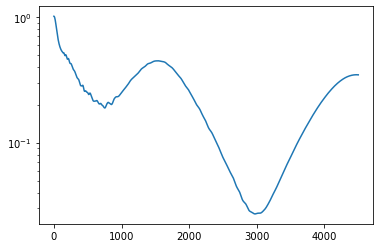

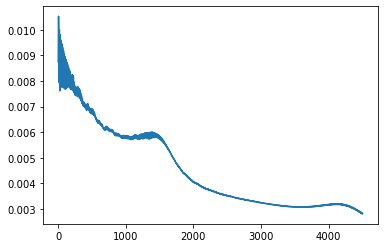

In [276]:
%matplotlib inline
a = np.sqrt(CBV.vortex_pair_rad[0,0,1:]**2 + CBV.vortex_pair_rad[1,0,1:]**2)
E = CBV.vortex_pair_rad[1,0,1:]/CBV.vortex_pair_rad[0,0,1:]
# plt.plot(CBV.vortex_pair_rad[0,0,1:])
# plt.plot(CBV.vortex_pair_rad[0,1,1:])
# plt.show()
# plt.plot(CBV.vortex_pair_rad[1,0,1:])
# plt.plot(CBV.vortex_pair_rad[1,1,1:])
# plt.show()
# plt.plot(a)
# plt.show()
# plt.plot(E)
# plt.semilogy(CBV.eulerResidual[1,:400])
# plt.plot(CBV.eulerResidual[0,:])
plt.semilogy(CBV.eulerResidual[1,:])
plt.show()
plt.plot(CBV.max_val_residual[0,1:])
plt.show()

In [31]:
%matplotlib widget
# plt.plot(CBV.vortex_pair_drift_vel[0,1:])
# # plt.plot(CBV.vortex_pair_drift_vel[1,1:])
# plt.show()

Y = CBV.vortex_pair_cent[1,1,:]
driftVel = np.gradient(Y,SV.dt,axis=0,edge_order=2)
plt.plot(driftVel)
# plt.plot(Y[1:]-Y[:-1])
# plt.plot(Y,'*')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

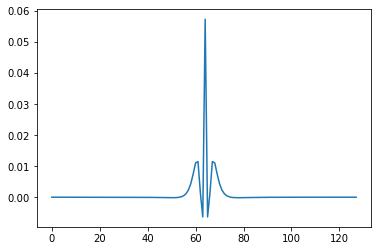

array([[56., 72.],
       [64., 64.]])

In [72]:
Nt = -1
Ut = SV.Ut[:,:,:,Nt]
Ut = np.copy(SV.U)
theta = SV.Lx*SV.K[0]/SV.nx + SV.Ly*SV.K[1]/SV.ny
sig_0 = 0.5*(1+np.cos(theta))
sig = sig_0**4*(35-84*sig_0 + 70*sig_0**2-20*sig_0**3)

Uf = rfft2(Ut)
W = np.zeros((SV.nx,SV.ny),dtype=dtype_re)
W = vorticity2D(Uf,SV)
S = streamfunction(Uf,SV)
W_d = vorticity2D_fd(Ut,SV)

plt.plot(W_d[int(70),:]*0.134**2)
plt.show()
XCind

In [320]:
Q = (W[:,:]*np.square(SV.Mesh[0,:,:]-xc))
Q = W[:,:]*np.square(SV.Mesh[0,:,:]- xc)
limits = np.array([[x1,x2],[y1,y2]])
# # Q = W_test[:,:]
areaIntegral(Q,SV,limits)/Gamma
# vortexPairRadius(SV,CBV)
# Q
# print(simps(simps(np.ones((SV.nx,SV.ny)),SV.Mesh[0,1,:]),SV.Mesh[0,:,1]))

0.004991636914200339

In [ ]:
# plt.contourf()
%matplotlib inline
# plt.contourf(SV.K[0],levels=50)
# plt.colorbar()
# plt.show()
# plt.contourf(SV.K[1],levels=50)
# plt.colorbar()
# plt.show()

fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.contourf(SV.fou_filt,levels=50)
plt.colorbar()

rec = mpl.patches.Rectangle([20,20], 20, 40, angle=0.0,fc ='none',ec ='r',lw = 1)
ax.add_patch(rec)
plt.show()